In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# 모듈정리

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter('ignore')

## 데이터 가져오기

In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
# train_data = pl.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
# test_data = pl.read_csv('/kaggle/input/playground-series-s4e7/test.cs

In [4]:
print(test_data.shape)
test_data.head()

(7669866, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [5]:
print(train_data.shape)
train_data.head()

(11504798, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
test_data["Response"] = 0
print(test_data.shape)
test_data.head()

(7669866, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228,0
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123,0
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271,0
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115,0
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148,0


In [7]:
merge_data = pd.concat([train_data, test_data])

In [8]:
print(merge_data.shape)
merge_data.head()

(19174664, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


### feature 정리
- `Gender`: 성별
- `Age`: 나이
- `Driving_License`: 운전면허 여부
- `Region_Code`: 지역
- `Previously_Insured`: 이전 보험등록여부
- `Vehicle_Age`: 자동차 연식
- `Vehicle_Damage`: 자동차 파손여부
- `Annual_Premium`: 연간 프리미엄??
- `Policy_Sales_Channel`: 정책판매 채널?
- `Vintage`: ??
- `Response`: 응답여부 타겟 데이터


## 훈련 데이터의 통합적인 정보

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


`object`는 수치형이 아니라 자료형이라 대부분 string이기 때문에 훈련하기 전에 전처리가 필요함

In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


수치값을 같는 데이터 정보

In [11]:
print(train_data.shape)
print(test_data.shape)
print(f"훈련 & 테스트 세트 비율:  {(test_data.shape[0]/train_data.shape[0])*100:5f}")

(11504798, 12)
(7669866, 12)
훈련 & 테스트 세트 비율:  66.666672


# EDA

## 데이터의 분포를 살피는 시각화

- 범주형 : bar
- 수치형
    - 이산형 : bar
    - 연속형 : kdeplot, histogram
    - 범주형 + 수치형 : boxplot, violinplot, etc
- 수치형 + 수치형 : scatter

> 이 외에도 다양한 방법이 존재하니 찾아보시는 것을 추천합니다.

In [118]:
merge_data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Response
0    10089739
1     1415059
Name: count, dtype: int64


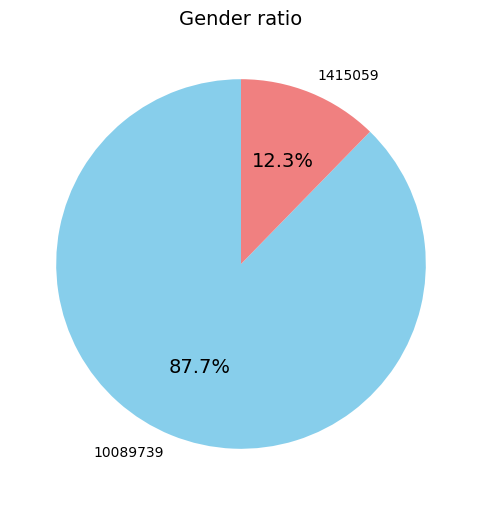

In [83]:
# 정답 불균형 체크
gender_count = train_data["Response"].value_counts()
print(gender_count)
plt.figure(figsize=(6,6))
plt.pie(gender_count, 
        labels=gender_count, 
        autopct="%1.1f%%", 
        colors=["skyblue", "lightcoral"],
       startangle=90
       )
plt.title("Gender ratio")
plt.show()


<Axes: >

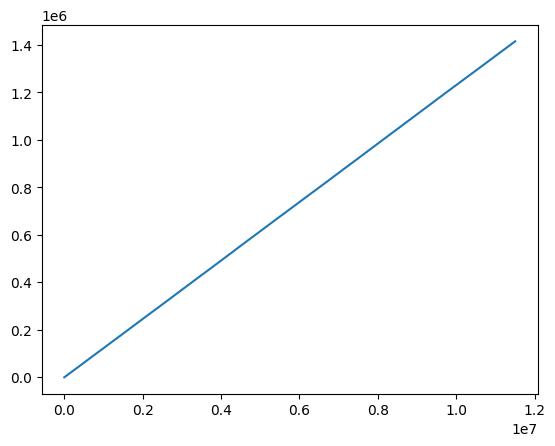

In [84]:
# 누출 체크
train_data["Response"].cumsum().plot()

In [86]:
categorical_features = []
numerical_features = []
for col in train_data.columns:
    
    if train_data[col].dtype == 'object':
        categorical_features.append(col)
        categories = train_data[col].unique()
        print(f"{col}: {categories} ({len(categories)})")
    
    elif col == "id":
        continue
        
    else:
        numerical_features.append(col)
    

Gender: ['Male' 'Female'] (2)
Vehicle_Age: ['1-2 Year' '> 2 Years' '< 1 Year'] (3)
Vehicle_Damage: ['Yes' 'No'] (2)


In [12]:
# 범주형 데이터 전처리
# encoder = LabelEncoder()
# merge_data = merge_data.apply(encoder.fit_transform)

merge_data = merge_data.replace({'Vehicle_Age':{'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
                                 'Gender':{'Male': 0, 'Female': 1},
                                 'Vehicle_Damage':{'Yes': 0, 'No': 1}
                                })

columns_to_convert = ['Vehicle_Age', 'Gender', 'Vehicle_Damage']
merge_data[columns_to_convert] = merge_data[columns_to_convert].astype('int64')


/tmp/ipykernel_33/3318290510.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_data = merge_data.replace({'Vehicle_Age':{'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},


In [13]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19174664 entries, 0 to 7669865
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                int64  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           int64  
 7   Vehicle_Damage        int64  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(9)
memory usage: 1.9 GB


In [14]:
train = merge_data[:train_data.shape[0]] 
test = merge_data[train_data.shape[0]:] 

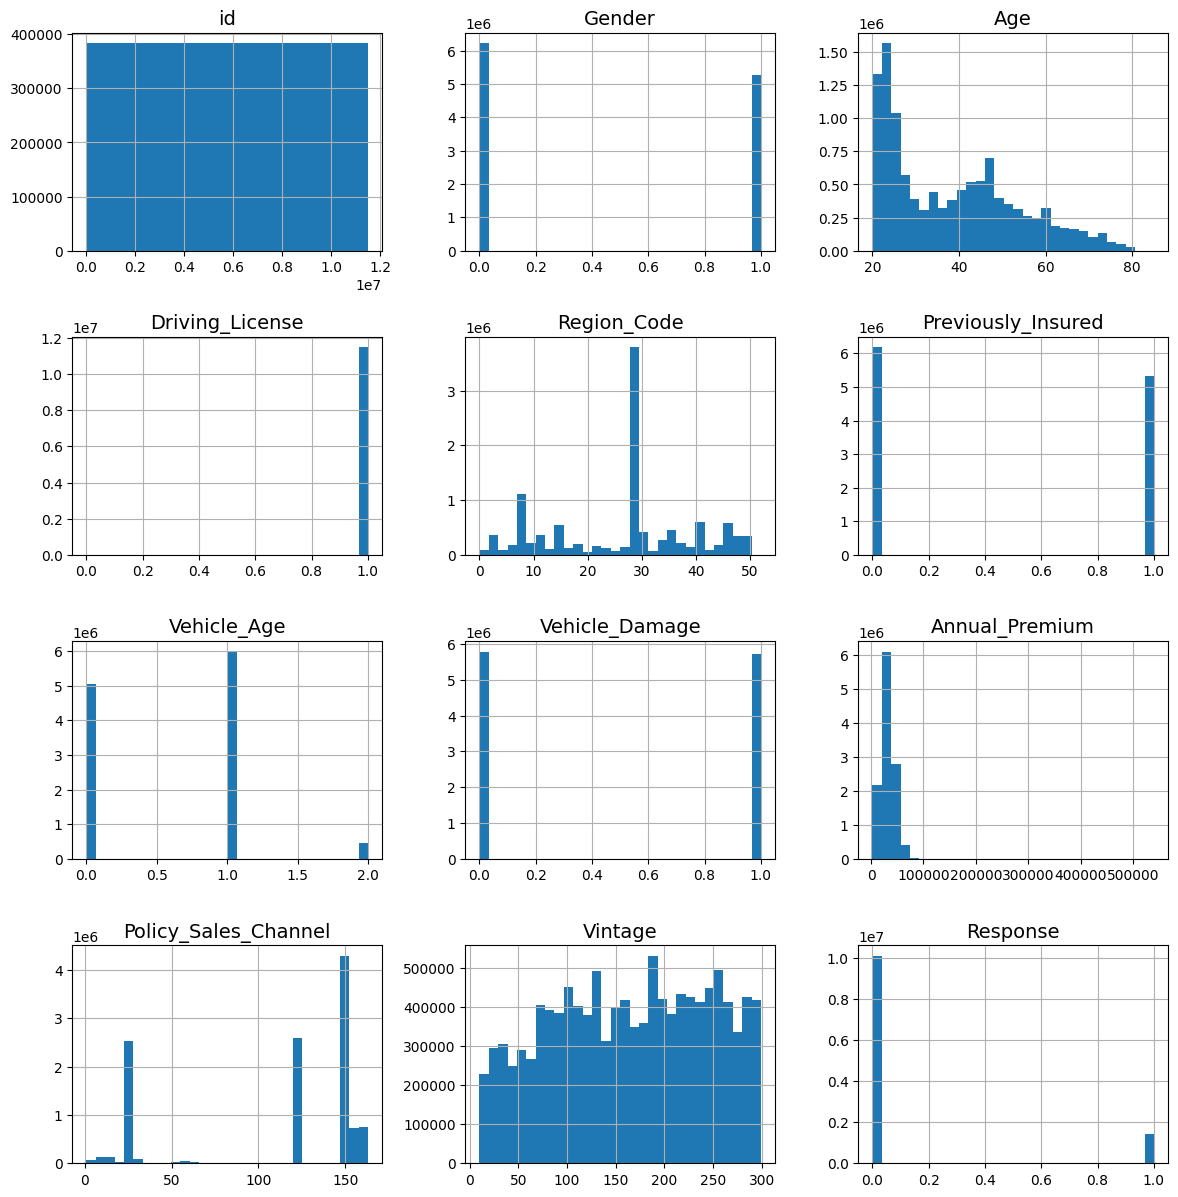

In [15]:
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

train.hist(bins=30, figsize=(12,15), layout=(5,3))

plt.tight_layout()
plt.show()

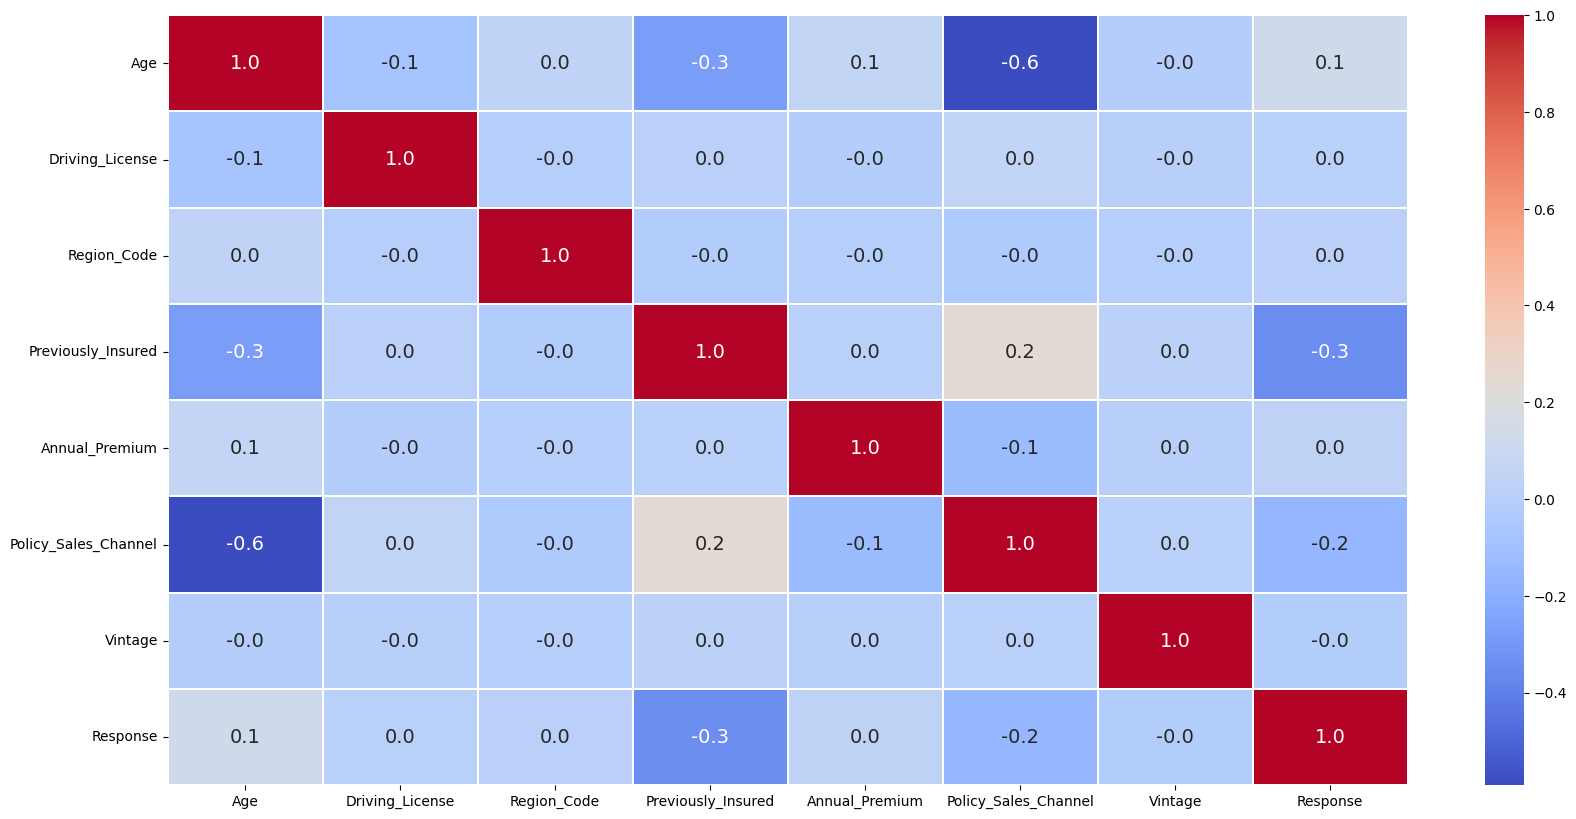

In [100]:
corr_matrix = train[numerical_features].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, 
           annot=True,
           cmap='coolwarm',
           fmt=".1f",
           linewidths=0.1)
plt.show()